In [32]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import numpy as np, seaborn as sns, matplotlib.pyplot as plt

import eda
import present_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pv = present_value.PresentValue()
anual_increment = pv.fetch_salary_increase_per_year()


c:\Code\practicum\src\eda.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [83]:
pv.present_value(75_620_666, 2014, 2025)


135340468.1932109

In [143]:
filename = "../data/raw/BASE DE DATOS PRESUPUESTOS.xlsx"
preproccesing = eda.EDA(filename)
df = preproccesing.create_dataset(pv.present_value_costs)

c:\Code\practicum\src\eda.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [71]:
def remove_outliers(df, target: str) -> pd.DataFrame:
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

In [148]:
def rmsle_scorer(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def train_model(df_clean, predictor_name, hue_name, target_name):
    X = df_clean[[predictor_name, hue_name]].copy()
    X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    pre = ColumnTransformer([
        ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    svr = SVR(kernel='rbf')
    pipe = Pipeline([('pre', pre), ('svr', svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

    param_grid = {
        'regressor__svr__C': [5, 10, 80, 200, 1000],
        'regressor__svr__epsilon': [0.01],
        'regressor__svr__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    }

    cv = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=min(5, len(y)//2), random_state=42) if len(y) >= 10 else LeaveOneOut()
    gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, refit=True)
    gs.fit(X, y)

    from sklearn.model_selection import cross_val_predict
    cv_simple = RepeatedKFold(n_splits=min(5, len(y)//2), n_repeats=1, random_state=42) if len(y) >= 10 else LeaveOneOut()
    y_oof = cross_val_predict(gs.best_estimator_, X, y, cv=cv_simple, n_jobs=-1)
    
    r2_oof = r2_score(y, y_oof)
    mae_oof = mean_absolute_error(y, y_oof)
    rmse_oof = np.sqrt(mean_squared_error(y, y_oof))
    rmsle_oof = rmsle_scorer(y, y_oof)
    mape_oof = np.mean(np.abs((y - y_oof) / y.replace(0, np.nan))) * 100

    print('Best params:', gs.best_params_)
    print({'R2': r2_oof, 'MAE': mae_oof, 'RMSE': rmse_oof, 'RMSLE': rmsle_oof, 'MAPE%': float(mape_oof)})
    
    y_predicted = y_oof

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].scatter(y, y_predicted, alpha=0.6); lim = [y.min(), y.max()]
    ax[0].plot(lim, lim, 'r--'); ax[0].set_title('Actual vs Pred'); ax[0].set_xlabel('Actual'); ax[0].set_ylabel('Predicted')
    sns.histplot(y - y_predicted, kde=True, ax=ax[1], color='slateblue'); ax[1].set_title('Residuals')
    plt.tight_layout(); plt.show()
    
    return X, y, y_predicted 
    

In [146]:
df['2.2 TRAZADO Y DISEÑO GEOMÉTRICO - KM'] = df['2.2 TRAZADO Y DISEÑO GEOMÉTRICO'] / df['LONGITUD KM']

*********2.2 TRAZADO Y DISEÑO GEOMÉTRICO - KM*********


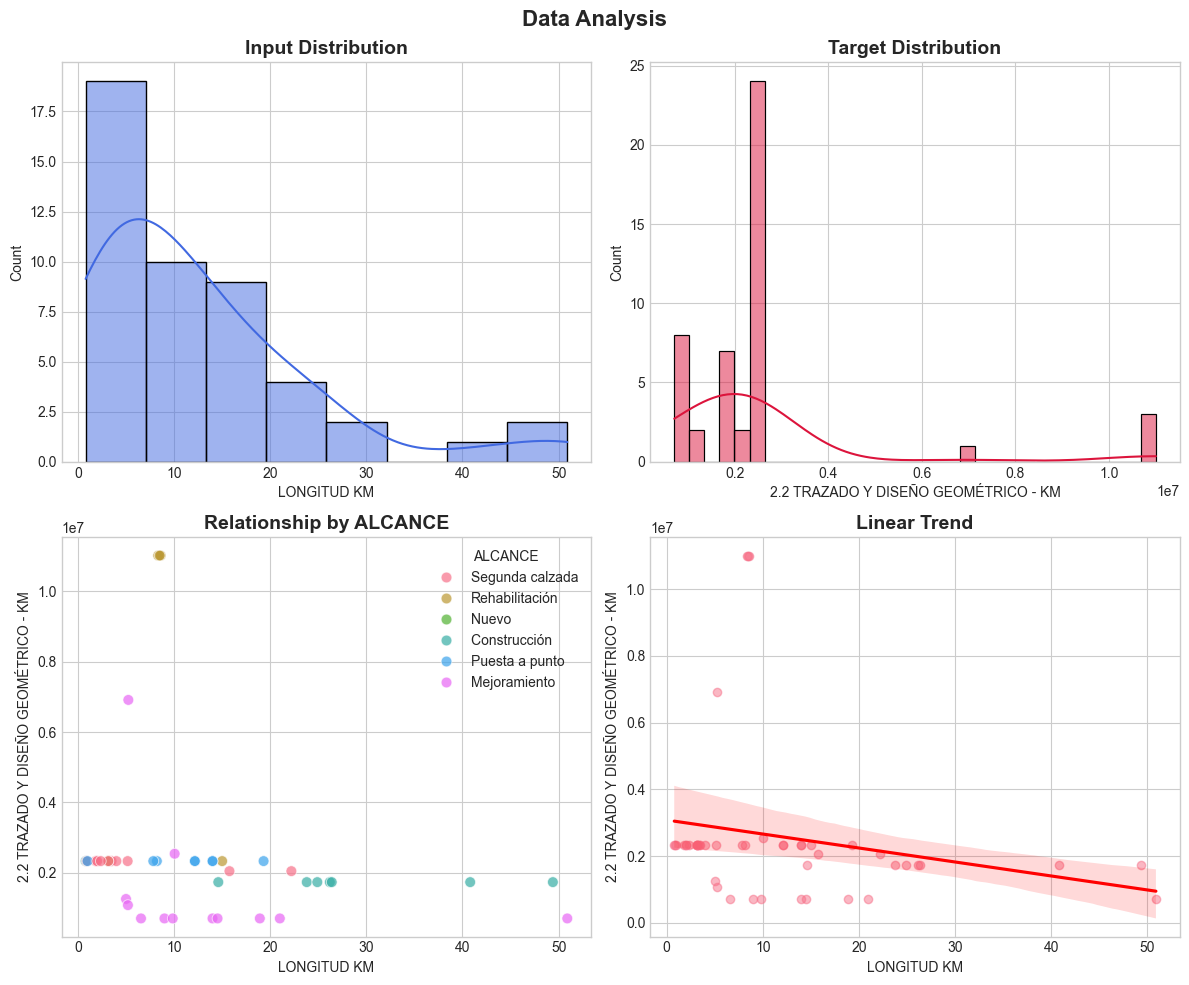

Best params: {'regressor__svr__C': 5, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 1.0}
{'R2': 0.8127785194548546, 'MAE': 361557.33293412783, 'RMSE': np.float64(1038343.4990775014), 'RMSLE': np.float64(0.4375145020946866), 'MAPE%': 17.00527269574586}


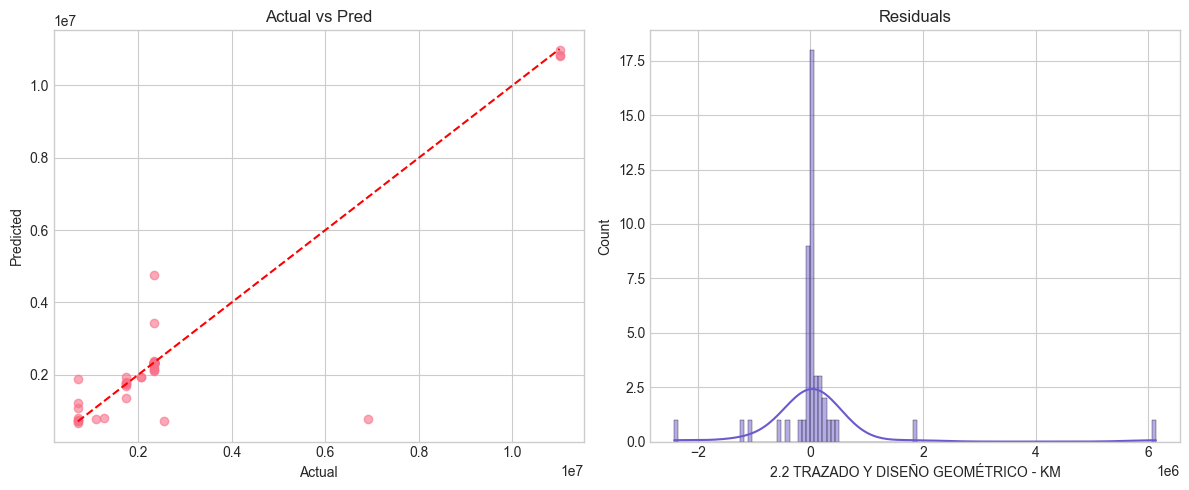

In [149]:
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_names_function_of_longitude = ['2.2 TRAZADO Y DISEÑO GEOMÉTRICO - KM']

for target_name in target_names_function_of_longitude:
    df_item = df.loc[:, [predictor_name, hue_name, target_name]]
    df_item_cleaned = remove_outliers(df_item, target_name)
    print(f'*********{target_name}*********')
    preproccesing.show_plots_eda(predictor_name, target_name, hue_name, df_item_cleaned)
    X, y, y_predicted = train_model(df_item_cleaned, predictor_name, hue_name, target_name)
    if target_name == '2.2 TRAZADO Y DISEÑO GEOMÉTRICO':
        break
    

In [120]:
X['ACTUAL'] = y
X['PREDICTED'] = y_predicted
output = X.drop(columns=['LONGITUD KM LOG'])
output['difference'] = abs(X['ACTUAL'] - X['PREDICTED'])
output.sort_values(by='difference', ascending=False)

,LONGITUD KM,ALCANCE,ACTUAL,PREDICTED,difference
0,15.760,Segunda calzada,2.051818e+06,9.709595e+06,7.657777e+06
26,17.400,Segunda calzada,7.778188e+06,2.021903e+06,5.756284e+06
25,5.243,Mejoramiento,6.910899e+06,1.170398e+06,5.740501e+06
2,15.000,Rehabilitación,2.337068e+06,4.676335e+06,2.339267e+06
27,10.060,Mejoramiento,2.545916e+06,7.018666e+05,1.844049e+06
1,22.200,Segunda calzada,2.051818e+06,3.802817e+06,1.750999e+06
16,3.150,Rehabilitación,2.337068e+06,3.711360e+06,1.374292e+06
30,50.900,Mejoramiento,7.096441e+05,2.057175e+06,1.347531e+06
46,49.400,Construcción,1.740049e+06,1.333822e+06,4.062273e+05
18,1.000,Puesta a punto,2.337068e+06,1.953297e+06,3.837714e+05


In [150]:
def calculate_cost_per_km(df, target_columns, length_column='LONGITUD KM'):
    df_cost_per_km = df.copy()
    for col in target_columns:
        df_cost_per_km[f'{col} PER KM'] = df_cost_per_km[col] / df_cost_per_km[length_column]
    return df_cost_per_km

target_columns = ['2.2 TRAZADO Y DISEÑO GEOMÉTRICO', '2.3 - SEGURIDAD VIAL', '2.4 - SISTEMAS INTELIGENTES', 
                  '5 - TALUDES', '6 - PAVIMENTO', '7 - SOCAVACIÓN', '11 - PREDIAL', 
                  '12 - IMPACTO AMBIENTAL', '15 - OTROS - MANEJO DE REDES']

df_per_km = calculate_cost_per_km(df, target_columns)
df_per_km.head()


,LONGITUD KM,PUENTES VEHICULARES UND,PUENTES VEHICULARES M2,PUENTES PEATONALES UND,PUENTES PEATONALES M2,TUNELES UND,TUNELES M2,ALCANCE,ZONA,TIPO TERRENO,...,2.2 TRAZADO Y DISEÑO GEOMÉTRICO - KM,2.2 TRAZADO Y DISEÑO GEOMÉTRICO PER KM,2.3 - SEGURIDAD VIAL PER KM,2.4 - SISTEMAS INTELIGENTES PER KM,5 - TALUDES PER KM,6 - PAVIMENTO PER KM,7 - SOCAVACIÓN PER KM,11 - PREDIAL PER KM,12 - IMPACTO AMBIENTAL PER KM,15 - OTROS - MANEJO DE REDES PER KM
0,15.76,4.0,6292.0,0.0,0.0,0.0,0.0,Segunda calzada,Rural,Montañoso,...,2.051818e+06,2.051818e+06,1.243927e+06,1.322973e+06,3.326421e+06,1.157232e+06,2.984419e+06,0.0,0.0,4.938726e+06
1,22.20,0.0,0.0,1.0,77.0,0.0,0.0,Segunda calzada,Rural,Montañoso,...,2.051818e+06,2.051818e+06,1.243927e+06,1.322973e+06,3.326421e+06,1.157232e+06,2.984419e+06,0.0,0.0,4.938726e+06
2,15.00,0.0,0.0,0.0,0.0,0.0,0.0,Rehabilitación,Rural,Ondulado,...,2.337068e+06,2.337068e+06,2.512247e+06,6.381305e+05,2.540390e+06,1.134319e+06,5.306414e+06,0.0,0.0,3.604718e+06
3,3.12,0.0,0.0,1.0,0.0,0.0,0.0,Nuevo,Rural,Montañoso,...,2.337068e+06,2.337068e+06,2.512247e+06,6.381305e+05,2.540390e+06,1.134319e+06,5.306414e+06,0.0,0.0,3.604718e+06
4,3.37,0.0,0.0,1.0,0.0,0.0,0.0,Segunda calzada,Rural,Montañoso,...,2.337068e+06,2.337068e+06,2.512247e+06,6.381305e+05,2.540390e+06,1.134319e+06,5.306414e+06,0.0,0.0,3.604718e+06


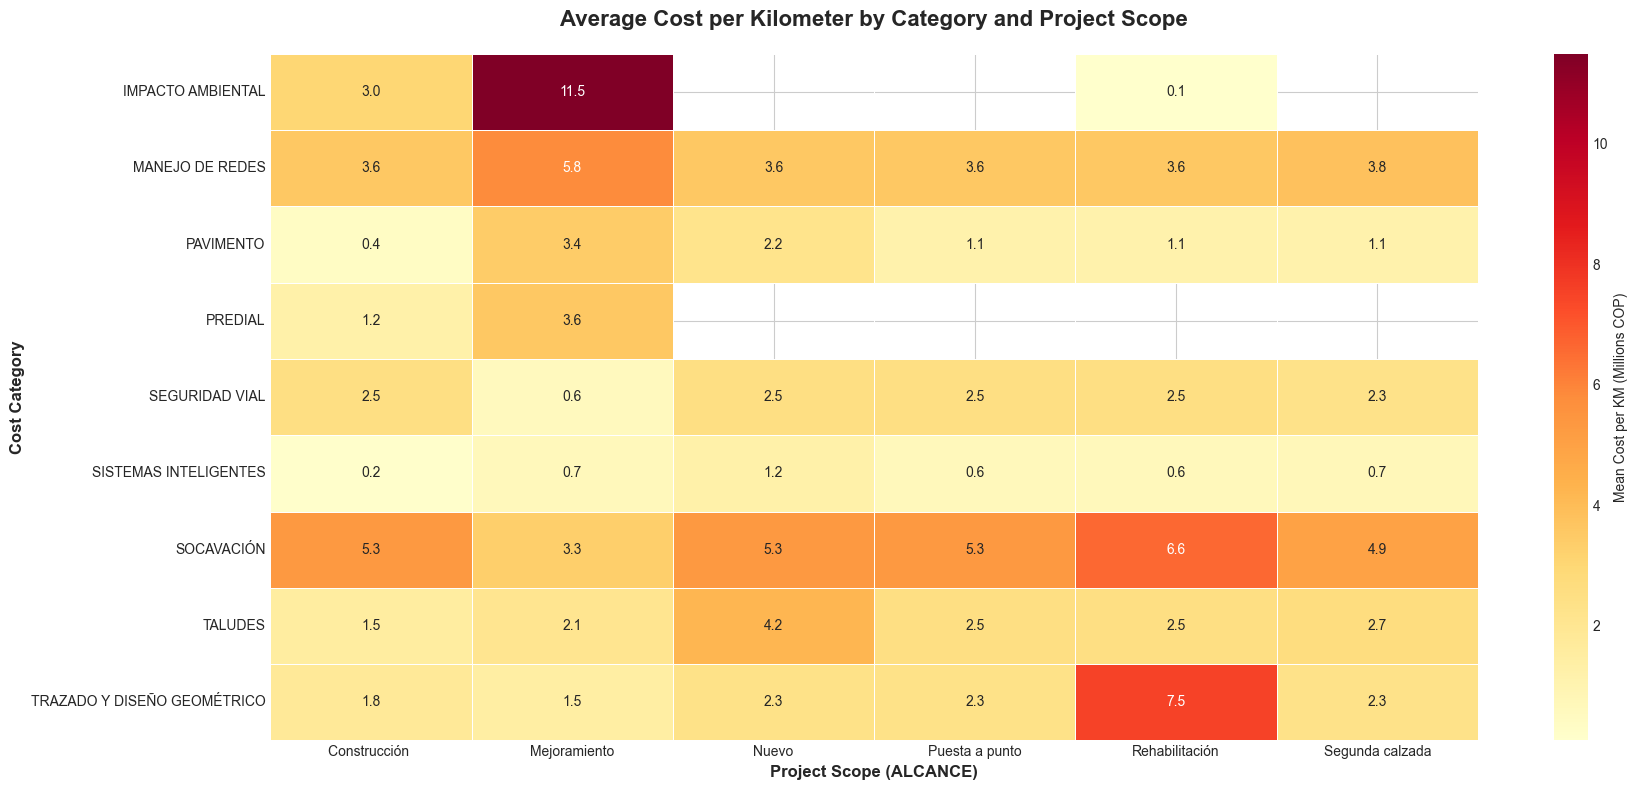

,Category,Alcance,Mean (M),Median (M),Std (M),Min (M),Max (M),Count
40,IMPACTO AMBIENTAL,Construcción,2.991642,2.991642,4.250887e-16,2.991642,2.991642,7
38,IMPACTO AMBIENTAL,Mejoramiento,11.493426,11.493426,1.580450e+01,0.317959,22.668894,2
39,IMPACTO AMBIENTAL,Rehabilitación,0.094271,0.094271,0.000000e+00,0.094271,0.094271,3
44,MANEJO DE REDES,Construcción,3.604718,3.604718,NaN,3.604718,3.604718,1
46,MANEJO DE REDES,Mejoramiento,5.802251,5.802251,NaN,5.802251,5.802251,1
43,MANEJO DE REDES,Nuevo,3.604718,3.604718,NaN,3.604718,3.604718,1
45,MANEJO DE REDES,Puesta a punto,3.604718,3.604718,3.048469e-16,3.604718,3.604718,8
42,MANEJO DE REDES,Rehabilitación,3.604718,3.604718,4.656613e-16,3.604718,3.604718,2
41,MANEJO DE REDES,Segunda calzada,3.809950,3.604718,5.009650e-01,3.604718,4.938726,13
27,PAVIMENTO,Construcción,0.365486,0.255653,3.106554e-01,0.255653,1.134319,8


In [151]:
def summarize_cost_per_km_by_alcance(df, target_columns, hue_column='ALCANCE'):
    summary_data = []
    
    for col in target_columns:
        per_km_col = f'{col} PER KM'
        df_clean = df[df[per_km_col] > 0]
        
        for alcance in df_clean[hue_column].unique():
            subset = df_clean[df_clean[hue_column] == alcance][per_km_col]
            
            summary_data.append({
                'Category': col.split(' - ')[-1] if ' - ' in col else col.split(' ', 1)[1],
                'Alcance': alcance,
                'Mean (M)': subset.mean() / 1e6,
                'Median (M)': subset.median() / 1e6,
                'Std (M)': subset.std() / 1e6,
                'Min (M)': subset.min() / 1e6,
                'Max (M)': subset.max() / 1e6,
                'Count': len(subset)
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    fig, ax = plt.subplots(figsize=(18, 8))
    pivot_mean = summary_df.pivot(index='Category', columns='Alcance', values='Mean (M)')
    
    sns.heatmap(pivot_mean, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, 
                cbar_kws={'label': 'Mean Cost per KM (Millions COP)'}, linewidths=0.5)
    ax.set_title('Average Cost per Kilometer by Category and Project Scope', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Project Scope (ALCANCE)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cost Category', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return summary_df.sort_values(['Category', 'Alcance'])

summary = summarize_cost_per_km_by_alcance(df_per_km, target_columns)
summary
